In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

In [3]:
data = pd.read_csv(fr"C:\projects\ML\DataBases\train2.csv")

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Разделяем на тренировочные и тестовые данные

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'),
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape, X_test.shape

((1022, 80), (438, 80))

In [ ]:
# Находим категориальные признаки
categorials = X_train.select_dtypes('object').columns
categorials

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
# закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
X_train[categorials] = X_train[categorials].fillna('nan')
X_test[categorials] = X_test[categorials].fillna('nan')

In [ ]:
# отфильтруем непрерывные признаки
integer = X_train.select_dtypes(['int', 'float']).columns.tolist()
integer.remove('Id')
X_train[integer].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
135,20,80.0,10400,7,6,1970,1970,288.0,0,0,...,530,98,0,0,0,0,0,0,5,2008
1452,180,35.0,3675,5,5,2005,2005,80.0,547,0,...,525,0,28,0,0,0,0,0,5,2006
762,60,72.0,8640,7,5,2009,2009,0.0,24,0,...,614,169,45,0,0,0,0,0,6,2010
932,20,84.0,11670,9,5,2006,2006,302.0,0,0,...,788,0,191,0,0,0,0,0,3,2007
435,60,43.0,10667,7,6,1996,1996,0.0,385,344,...,550,158,61,0,0,0,0,0,4,2009


In [ ]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[categorials], columns=categorials)
dummy_test = pd.get_dummies(X_test[categorials], columns=categorials)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([X_train[integer].fillna(-999), dummy_train], axis=1)

X_test = pd.concat([X_test[integer].fillna(-999), dummy_test], axis=1)

In [ ]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Condition1_PosN,SaleType_COD,ExterCond_Ex,GarageType_Basment,Exterior2nd_Brk Cmn,RoofMatl_CompShg,BsmtQual_nan,SaleType_New,KitchenQual_Fa,SaleCondition_Partial
135,20,80.0,10400,7,6,1970,1970,288.0,0,0,...,False,False,False,False,False,True,False,False,False,False
1452,180,35.0,3675,5,5,2005,2005,80.0,547,0,...,False,False,False,True,False,True,False,False,False,False
762,60,72.0,8640,7,5,2009,2009,0.0,24,0,...,False,False,False,False,False,True,False,False,False,False
932,20,84.0,11670,9,5,2006,2006,302.0,0,0,...,False,False,False,False,False,True,False,False,False,False
435,60,43.0,10667,7,6,1996,1996,0.0,385,344,...,True,False,False,False,False,True,False,False,False,False


## Бэггинг

In [ ]:
from sklearn.ensemble import  BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dt = DecisionTreeRegressor(random_state=10)
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

1.0

In [ ]:
dt.score(X_test, y_test)

0.7578533412811429

In [ ]:
bagging = BaggingRegressor(DecisionTreeRegressor(),
                           n_estimators=10,
                           max_samples=0.5,
                           max_features=0.5,
                           random_state=10)

In [ ]:
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_features=0.5,
                 max_samples=0.5, random_state=10)

In [ ]:
bagging.score(X_train, y_train)

0.9092184422020717

In [ ]:
bagging.score(X_test, y_test)

0.8314354471382056

In [ ]:
kn = KNeighborsRegressor()
kn.fit(X_train, y_train)
kn.score(X_train, y_train)

0.7501837788800589

In [ ]:
kn.score(X_test, y_test)

0.676138613361793

In [ ]:
bagging = BaggingRegressor(KNeighborsRegressor(),
                           n_estimators=100,
                           max_samples=0.5,
                           max_features=0.5,
                           random_state=10)

In [ ]:
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=KNeighborsRegressor(), max_features=0.5,
                 max_samples=0.5, n_estimators=100, random_state=10)

In [ ]:
bagging.score(X_train, y_train)

0.7465713417547813

In [ ]:
bagging.score(X_test, y_test)

0.719744517888113

### RandomForest

In [ ]:
# Создаем модель RandomForest
clf_rf = RandomForestRegressor(random_state=10)
clf_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [ ]:
# проверяем полученные данные на тренировочных данных

clf_rf.score(X_train, y_train)

0.9782771515134925

In [ ]:
# проверяем полученные данные на тестовых данных

clf_rf.score(X_test, y_test)

0.8928647253445354

In [ ]:
# Выявляем наиболее важные признаки и выводим на график. Большое значение имеет признак Overall Qual, остальные почти равны нулю

imp = pd.Series(clf_rf.feature_importances_)

In [ ]:
imp.index = pd.Series(X_train.columns)

In [ ]:
imp = imp.sort_values(ascending=False)
imp

OverallQual         5.393803e-01
GrLivArea           1.237020e-01
2ndFlrSF            3.931704e-02
TotalBsmtSF         2.952660e-02
1stFlrSF            2.209917e-02
                        ...     
SaleType_Oth        5.644686e-10
GarageQual_Po       2.392876e-10
BsmtCond_Po         0.000000e+00
MiscFeature_Gar2    0.000000e+00
Utilities_AllPub    0.000000e+00
Length: 268, dtype: float64

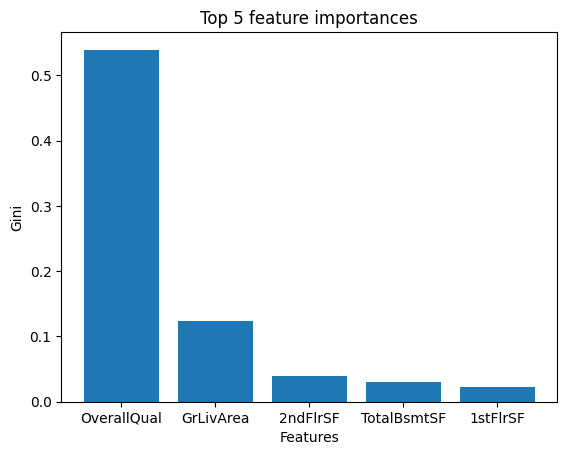

In [ ]:
plt.title('Top 5 feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.head().index, imp.head())
plt.show()

## Стекинг

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

In [ ]:
# Создаем стэккинг и обучаем его на наших данных 

Regressor = StackingRegressor(
    [
        ('LinearRegression', LinearRegression()),
        ('KNeighborsRegressor', KNeighborsRegressor()),
        ('DecisionTree', DecisionTreeRegressor())
    ], RidgeCV())

In [ ]:
Regressor.fit(X_train, y_train)

StackingRegressor(estimators=[('LinearRegression', LinearRegression()),
                              ('KNeighborsRegressor', KNeighborsRegressor()),
                              ('DecisionTree', DecisionTreeRegressor())],
                  final_estimator=RidgeCV())

In [ ]:
print(f'Score on train  {Regressor.score(X_train, y_train)}')
print(f'Score on test  {Regressor.score(X_test, y_test)}')

Score on train  0.9610517218573349
Score on test  0.8655928661260797


In [ ]:
for i in Regressor.named_estimators:
    print(f'Score on train  with model {i} {Regressor.named_estimators_[i].score(X_train, y_train)}')
    print(f'Score on test  with model {i} {Regressor.named_estimators_[i].score(X_test, y_test)}')

Score on train  with model LinearRegression 0.932432942018947
Score on test  with model LinearRegression 0.8085032059452782
Score on train  with model KNeighborsRegressor 0.7501837788800589
Score on test  with model KNeighborsRegressor 0.676138613361793
Score on train  with model DecisionTree 1.0
Score on test  with model DecisionTree 0.7797874438441289


Лучше всех справилась Линейная регрессия.
Деревья решений, как и предполагалось, переобучилась. Алгоритм ближайшего соседа тоже не плохо справилась с задачей. 

## Бустинг

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

boosting = GradientBoostingRegressor(n_estimators=100,
                                     random_state=10)

In [ ]:
boosting.fit(X_train, y_train)

GradientBoostingRegressor(random_state=10)

In [ ]:
boosting.score(X_train, y_train)

0.9715180667981475

In [ ]:
boosting.score(X_test, y_test)

0.9119918200175823

### lightgbm

In [ ]:
from lightgbm import LGBMRegressor

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
lgbm = LGBMRegressor(random_state=10)
lgbm.fit(X_train, y_train)

LGBMRegressor(random_state=10)

In [ ]:
lgbm.score(X_train, y_train)

0.9763722880428561

In [ ]:
lgbm.score(X_test, y_test)

0.902080756223816

### xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(random_state=10)
xgb.fit(X_train, y_train)

[07:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=10)

In [ ]:
xgb.score(X_train, y_train)

0.9667036051435475

In [ ]:
xgb.score(X_test, y_test)

0.8920635669400951

### catboost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 88 kB/s 


In [ ]:
from catboost import CatBoostRegressor 

In [ ]:
cat = CatBoostRegressor(random_state=10)
cat.fit(X_train, y_train)

Learning rate set to 0.041084
0:	learn: 75584.5202765	total: 55.1ms	remaining: 55.1s
1:	learn: 73896.9793127	total: 62.7ms	remaining: 31.3s
2:	learn: 71996.5931756	total: 69.6ms	remaining: 23.1s
3:	learn: 70279.2481167	total: 76.1ms	remaining: 19s
4:	learn: 68554.0367207	total: 82.5ms	remaining: 16.4s
5:	learn: 67218.2073599	total: 89.5ms	remaining: 14.8s
6:	learn: 65661.8358133	total: 96.3ms	remaining: 13.7s
7:	learn: 64134.4971239	total: 103ms	remaining: 12.7s
8:	learn: 62825.8674463	total: 109ms	remaining: 12s
9:	learn: 61517.3265793	total: 116ms	remaining: 11.4s
10:	learn: 60221.1749933	total: 122ms	remaining: 10.9s
11:	learn: 58928.4605791	total: 128ms	remaining: 10.5s
12:	learn: 57835.3166136	total: 134ms	remaining: 10.2s
13:	learn: 56751.0317434	total: 141ms	remaining: 9.93s
14:	learn: 55566.0605820	total: 148ms	remaining: 9.71s
15:	learn: 54252.6864933	total: 155ms	remaining: 9.5s
16:	learn: 53255.8256304	total: 161ms	remaining: 9.31s
17:	learn: 52266.1147753	total: 167ms	remai

In [ ]:
cat.score(X_train, y_train)

0.9955578655041462

In [ ]:
cat.score(X_test, y_test)

0.920340752259986